In [1]:
import matplotlib.pyplot as plt
import os
from project_classes import *
from functions import *
from iceflow_library import *
from scipy.optimize import curve_fit
import scipy.optimize as opt
import sys

In [3]:
zoom = True
seg_length = 100
# season = "2009_Antarctica_DC8"
season = "2018_Antarctica_DC8"
# season = "2016_Antarctica_DC8" 
# season = "2014_Antarctica_DC8" 
season = "2022_Antarctica_BaslerMKB"

# flight = "20181030_01"  # the flight date and frame number 
# that flight only has one point
flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181011_01"
# one dimensional data error
# TODO: figure out why 10018 and 1103 have the same data or at least print the same maps and plots
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
# plots fake crossovers along the curved path
# flight = "20161024_05"
# flight = "20161111_05"
# probably too close to the coast to be useful
# flight = "20161024_05"
# flight = "20141026_06"
flight = "20230127_01"
# ~ 1/3 of an orbit of the pole and yet the angle plot looks like hot garbage
# file_name = "layer_export_" + flight + ".pickle"
file_name = "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
testing = False

In [4]:
print(f"Force remaking {file_name}...")
mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
layers = read_layers(file_name)  # read in the layers from the pickle file
print(f"File {file_name} created.")

if not os.path.isfile(
        "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle"):  # if the file does not exist
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
# try:
iceflow_data = iceflow_loader("C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle")
print("The iceflow data pickle file was found and loaded.")

x = iceflow_data[0]
y = iceflow_data[1]
velocity_x = iceflow_data[2]
velocity_y = iceflow_data[3]
latitude = iceflow_data[4]
longitude = iceflow_data[5]
print("iceflow data loaded")

filename = f"C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"

print(f"Force remaking {file_name}...")


Force remaking C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20230127_01.pickle...
Reading data files...
--------------------
f['param']: <HDF5 group "/param" (6 members)>
f['param'].keys(): ['day_seg', 'radar', 'radar_name', 'records', 'season_name', 'sw_version']


layerize_h5py debug:
f['lat'][:]: [[-88.89395645]
 [-88.89382215]
 [-88.89368786]
 ...
 [-88.44666919]
 [-88.44653489]
 [-88.4464006 ]]
f['lat'][:]: -88.8939564477804



layer1: Surface number of points: 96358
layer2: Bottom number of points: 96358
--------------------
C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20230127_01.pickle  saved in local directory of this python file.
--------------------

Reading pickle file...
--------------------
Surface
Bottom
--------------------

File C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20230127_01.pickle created.
The iceflow data pickle file was found and loaded.
iceflow data loaded
Force remaking C:\Users\rj\Documents\cresis_project\

In [6]:
intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
with open(filename, 'wb') as file:
    pickle.dump(intersection_indices, file)
    pickle.dump(intersection_points, file)
    pickle.dump(segment_ends, file)
print(f"intersection_indices and intersection_points saved to {filename}")

Finding crossover point...
--------------------
Checking for intersections...
[====================] 100.0%
[====================] 100.0%
Number of intersections: 6
--------------------

intersection_indices and intersection_points saved to C:\Users\rj\Documents\cresis_project\pickle_jar\2022_Antarctica_BaslerMKB_20230127_01_crossover_points.pickle


In [7]:
# print the lat-lon and twtt of the first crossover point

# print(f"layers[1].lat[0]: {layers[1].lat[0]}")
#                             layers[1].lon[index][0])
print(f"segment_ends[0][0][0]: {segment_ends[0][0][2]}")
print(f"segment_ends[0][0]: {segment_ends[0][0]}")


segment_ends[0][0][0]: 29253
segment_ends[0][0]: [(-85.95336842784279, -104.31383823598436), (-85.95325594062754, -104.31279852896284), 29253]


point: nan is not 0. Hopefully it is nan.
point: nan is not 0. Hopefully it is nan.
first cross lat-lon: -85.95336842784279, -104.31383823598436
first segment lat-lon: -85.95325594062754, -104.31279852896284
first cross twtt: 2.2062186341800812e-05
intersection point 0: [-85.95336842784279, -104.31383823598436]


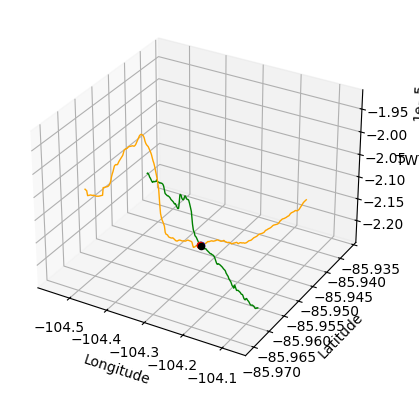

In [8]:
def plot_layers_3d(layers, season, flight, intersect_indices, seg_ends):
    # plot the layers with respect to lat, lon, and twtt
    # plot a grid of scattered points at 0 twtt to represent the surface

    # convert the lat-lon points to xy points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    plot_all = False
    # plot_all = True
    plot_surface = False

    for layer in layers:
        corrected_twtt = layer.twtt - layers[0].twtt  # normalize against the surface layer
        # corrected_twtt = layer.twtt
        layer.twtt_corrected = corrected_twtt

    for point in layers[0].twtt_corrected:
        if point != 0:
            print(f"point: {point} is not 0. Hopefully it is nan.")

    lats_bottom = []
    lons_bottom = []
    twtts_bottom = []
    lats_surf = []
    lons_surf = []
    twtts_surf = []

    for i in range(len(layers[1].lat)):
        lats_bottom.append(layers[1].lat[i])
        lons_bottom.append(layers[1].lon[i])
        twtts_bottom.append(layers[1].twtt_corrected[i])
        # twtts1.append(layers[1].twtt[index])

    for i in range(len(layers[0].lat)):
        lats_surf.append(layers[0].lat[i])
        lons_surf.append(layers[0].lon[i])
        twtts_surf.append(layers[0].twtt_corrected[i])
        # twtts2.append(layers[0].twtt[index])

    # offset = 250
    offset = 150

    i=0
    # for index in range(len(intersect_indices) - 1):

    if plot_surface:
        # plot the surface layer (layer 0)
        ax.plot(lons_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
                lats_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
                [-x for x in (twtts_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset])], label='top. seg. 1', c='blue',
                linewidth=1)

        ax.plot(lons_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
                lats_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
                [-x for x in (twtts_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset])], label='top seg. 2', c='black',
                linewidth=1)

        # draw a line from one end of the segment to the other in blue
        # Define the slice range
        start_index = intersect_indices[i][0] - offset
        end_index = intersect_indices[i][0] + offset

        # Extract the sliced arrays
        lons2_slice = lons_surf[start_index:end_index]
        lats2_slice = lats_surf[start_index:end_index]
        twtts2_slice = [-x for x in twtts_surf[start_index:end_index]]

        # plot the distance in meters between the first and last point
        # get the distance in meters between the first and last point
        distance = latlon_dist([lats2_slice[0], lons2_slice[0]], [lats2_slice[-1], lons2_slice[-1]])
        # plot the distance in meters to the first decimal between the first and last point
        ax.text((lons2_slice[0]), (lats2_slice[0]),
                (max(twtts2_slice[0], twtts2_slice[-1])), f"{distance:.1f}m", color='blue')



    start_index_seg1 = intersect_indices[i][1] - offset
    end_index_seg2 = intersect_indices[i][1] + offset

    start_index_seg2 = intersect_indices[i][0] - offset
    end_index_seg1 = intersect_indices[i][0] + offset

    # plot the bottom layer (layer 1)
    # plot.plot(lons_bottom[intersect_indices[index][0] - offset:intersect_indices[index][0] + offset],
    #         lats_bottom[intersect_indices[index][0] - offset:intersect_indices[index][0] + offset],
    #         [-x for x in (twtts_bottom[intersect_indices[index][0] - offset:intersect_indices[index][0] + offset])],
    #         label='bott. seg. 1', c='orange',
    #         linewidth=1)
    #
    # plot.plot(lons_bottom[intersect_indices[index][1] - offset:intersect_indices[index][1] + offset],
    #         lats_bottom[intersect_indices[index][1] - offset:intersect_indices[index][1] + offset],
    #         [-x for x in (twtts_bottom[intersect_indices[index][1] - offset:intersect_indices[index][1] + offset])],
    #         label='bott. seg. 2', c='green',
    #         linewidth=1)

    ax.plot(lons_bottom[start_index_seg1:end_index_seg2],
            lats_bottom[start_index_seg1:end_index_seg2],
            [-x for x in twtts_bottom[start_index_seg1:end_index_seg2]],
            label='bott. seg. 2', c='green', linewidth=1)

    ax.plot(lons_bottom[start_index_seg2:end_index_seg1],
            lats_bottom[start_index_seg2:end_index_seg1],
            [-x for x in twtts_bottom[start_index_seg2:end_index_seg1]],
            label='bott. seg. 1', c='orange', linewidth=1)


    if plot_all:
        # plot the rest of the bottom layer
        ax.plot(lons_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                lats_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                [-x for x in (twtts_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset])], label='whole bottom', c='purple',
                linewidth=0.25)

        # plot the rest of the surface layer
        ax.plot(lons_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                lats_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                [-x for x in (twtts_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset])], label='whole surface', c='grey',
                linewidth=0.25)

    # plot the intersection points
    i = 0

    # for index in range(len(intersection_points) - 1):
    # plot.scatter(intersection_points[index][1], intersection_points[index][0], -1 * twtts_bottom[intersect_indices[index][0]],
    #            c='red', marker='o')
    # plot.scatter(intersection_points[index][1], intersection_points[index][0], -1 * twtts_bottom[intersect_indices[index][1]],
    #            c='black', marker='o')
    #
    # plot.scatter(layers[1].lon[intersect_indices[index][0]],
    #            layers[1].lat[intersect_indices[index][0]],
    #            -1 * layers[1].twtt_corrected[intersect_indices[index][0]], c='green', marker='o')
    # plot.scatter(layers[1].lon[intersect_indices[index][1]],
    #            layers[1].lat[intersect_indices[index][1]],
    #            -1 * layers[1].twtt_corrected[intersect_indices[index][1]], c='blue', marker='o')

    # plot the segment_ends
    # for index in range(len(seg_ends)-1):
    
        # plot.scatter(seg_ends[index][0][0][0], seg_ends[index][0][0][1], -1 * corrected_twtt[seg_ends[index][0][2]], c='red', marker='o')
        # plot.scatter(seg_ends[index][0][0][1], seg_ends[index][0][0][0], -1 * corrected_twtt[seg_ends[index][0][2]], c='red', marker='o')

    # plot just the first 4 segment ends
    for i in range(1):
        ax.scatter(seg_ends[i][0][0][1], seg_ends[i][0][0][0], -1 * corrected_twtt[seg_ends[i][0][2]], c='red', marker='o')
        ax.scatter(seg_ends[i][0][1][1], seg_ends[i][0][1][0], -1 * corrected_twtt[seg_ends[i][0][2]], c='blue', marker='o')
        ax.scatter(seg_ends[i][1][0][1], seg_ends[i][1][0][0], -1 * corrected_twtt[seg_ends[i][1][2]], c='green', marker='o')
        ax.scatter(seg_ends[i][1][1][1], seg_ends[i][1][1][0], -1 * corrected_twtt[seg_ends[i][1][2]], c='black', marker='o')

    # index = 0
    # plot.scatter(seg_ends[index][0][0][0], seg_ends[index][0][0][1], -1 * corrected_twtt[seg_ends[index][0][2]], c='red', marker='o')
    
    print(f"first cross lat-lon: {seg_ends[i][0][0][0]}, {seg_ends[i][0][0][1]}")
    print(f"first segment lat-lon: {seg_ends[i][0][1][0]}, {seg_ends[i][0][1][1]}")
    print(f"first cross twtt: {corrected_twtt[seg_ends[i][0][2]]}")


    # print(f"by way of twtt_bottom: \t{twtts_bottom[intersect_indices[index][0]]}")  # red one
    # print(f"by way of twtt_bottom: \t{twtts_bottom[intersect_indices[index][1]]}")  # black one
    # print(f"by way of twtt_corrected: \t{layers[1].twtt_corrected[intersect_indices[index][0]]}")  # green one
    # print(f"by way of twtt_corrected: \t{layers[1].twtt_corrected[intersect_indices[index][1]]}")  # blue one



    #     # label the points with their index
    print(f"intersection point {i}: {intersection_points[i]}")


    # add a legend without the whole bottom and whole surface
    # plot.legend(labels=[f'{l.get_label()}' for l in plot.lines[::2]], bbox_to_anchor=(1.1, 1.05))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('TWTT')
    plt.show()

plot_layers_3d(layers, season, flight, intersection_indices, segment_ends)

In [6]:
print(segment_ends[0][0][0])
print(segment_ends[0][0][1])
print(segment_ends[0][0])
print("")
print(segment_ends[0][1][0])
print(segment_ends[0][1][1])
print(segment_ends[0][1])
print("")
print(segment_ends[0])


(-85.95336842784279, -104.31383823598436)
(-85.95325594062754, -104.31279852896284)
[(-85.95336842784279, -104.31383823598436), (-85.95325594062754, -104.31279852896284), 29253]

(-85.95332237124342, -104.31346984061088)
(-85.95339582068333, -104.31187657863418)
[(-85.95332237124342, -104.31346984061088), (-85.95339582068333, -104.31187657863418), 63621]

[[(-85.95336842784279, -104.31383823598436), (-85.95325594062754, -104.31279852896284), 29253], [(-85.95332237124342, -104.31346984061088), (-85.95339582068333, -104.31187657863418), 63621]]
